<a href="https://colab.research.google.com/github/AmritttSingh/PyTorch_Tutorial/blob/main/First_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [129]:
#conver mnist image files into a tensor of 4D
transform = transforms.ToTensor()

In [130]:
#train
train_data = datasets.MNIST(root='/cnn_data',train=True,download=True,transform=transform)

In [131]:
#train
test_data = datasets.MNIST(root='/cnn_data',train=False,download=True,transform=transform)

In [132]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [133]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [134]:
#create small batch size of images - 10
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [135]:
#define our CNN model
#desc cnn layer and whats it doing(2cnn layers)
#just an example

#(in_channels: int, out_channels: int, kernel_size: _size_2_t, stride: _size_2_t = 1, padding: _size_2_t | str = 0, dilation: _size_2_t = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros', device: Any | None = None, dtype: Any | None = None) -> None

conv1 = nn.Conv2d(1,6,3,1) #1 inp, 6 feature map, 3 kernelsize, 1 stride
conv2 = nn.Conv2d(6,16,3,1) #6 inp, 16 feature map, 3 kernelsize, 1 stride

In [136]:
#grab 1 mnist image
for i, (X_train,Y_train) in enumerate(train_data):
  break

In [137]:
X_train.shape

torch.Size([1, 28, 28])

In [138]:
X = X_train.view(1,1,28,28) #conv to 4d

In [139]:
#perform first convolution
X = F.relu(conv1(X))

In [140]:
X.shape

torch.Size([1, 6, 26, 26])

In [141]:
#pass thru pooling layer
X = F.max_pool2d(X,2,2) #kernel of 2 and stride of 2

In [142]:
X.shape

torch.Size([1, 6, 13, 13])

In [143]:
#second conv layer
X = F.relu(conv2(X))

In [144]:
X.shape

torch.Size([1, 16, 11, 11])

In [145]:
#pooling layer
X = F.max_pool2d(X,2,2)

In [146]:
X.shape # (((28-2)/2) -2)/2 = 5

torch.Size([1, 16, 5, 5])

In [155]:
#model class
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    #fc layer
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,X):
      #first pass
      X = F.relu(self.conv1(X))
      X = F.max_pool2d(X,2,2)
      #second pass
      X = F.relu(self.conv2(X))
      X = F.max_pool2d(X,2,2)

      #re view and flatten it out
      X = X.view(-1,16*5*5) #-1 so we can vary batch size

      #fully connected layers
      X = F.relu(self.fc1(X))
      X = F.relu(self.fc2(X))
      X = self.fc3(X)

      return F.log_softmax(X,dim=1)

In [156]:
#creating instance of model

torch.manual_seed(41)
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [157]:
#loss func optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [160]:
import time
start_time = time.time()

#variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#for loop of epoch
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  #train
  for b,(X_train,Y_train) in enumerate(train_loader):
    b+=1
    Y_pred = model(X_train)
    loss = criterion(Y_pred,Y_train)

    predicted = torch.max(Y_pred,1)[1] #add up the no. of correct predictions. Indexed off the first point
    batch_corr = (predicted == Y_train).sum()
    trn_corr += batch_corr

    #update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print out some results
    if b%600 == 0:
      print(f'Epoch:{i} Batch:{b} Loss:{loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  #test
  with torch.no_grad():
    for b,(X_test,Y_test) in enumerate(test_loader):
      Y_val = model(X_test)
      predicted = torch.max(Y_val.data,1)[1]
      tst_corr += (predicted == Y_test).sum()

  loss=criterion(Y_val,Y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time= time.time()
total = current_time - start_time
print(f'Training time: {total/60} minutes!')

Epoch:0 Batch:600 Loss:0.0015550360549241304
Epoch:0 Batch:1200 Loss:0.0016640543472021818
Epoch:0 Batch:1800 Loss:0.0014323515351861715
Epoch:0 Batch:2400 Loss:0.0014698707964271307
Epoch:0 Batch:3000 Loss:0.003533406648784876
Epoch:0 Batch:3600 Loss:6.788404425606132e-05
Epoch:0 Batch:4200 Loss:0.01356517057865858
Epoch:0 Batch:4800 Loss:0.02494993433356285
Epoch:0 Batch:5400 Loss:4.3281226680846885e-05
Epoch:0 Batch:6000 Loss:0.08026562631130219
Epoch:1 Batch:600 Loss:4.7541670937789604e-05
Epoch:1 Batch:1200 Loss:0.03551480919122696
Epoch:1 Batch:1800 Loss:0.0014768592081964016
Epoch:1 Batch:2400 Loss:0.23901721835136414
Epoch:1 Batch:3000 Loss:0.0004619716783054173
Epoch:1 Batch:3600 Loss:0.11063989251852036
Epoch:1 Batch:4200 Loss:0.01616169512271881
Epoch:1 Batch:4800 Loss:4.18398340116255e-05
Epoch:1 Batch:5400 Loss:1.901343603094574e-05
Epoch:1 Batch:6000 Loss:0.007096839137375355
Epoch:2 Batch:600 Loss:9.03587533684913e-06
Epoch:2 Batch:1200 Loss:0.004855274222791195
Epoch:2 

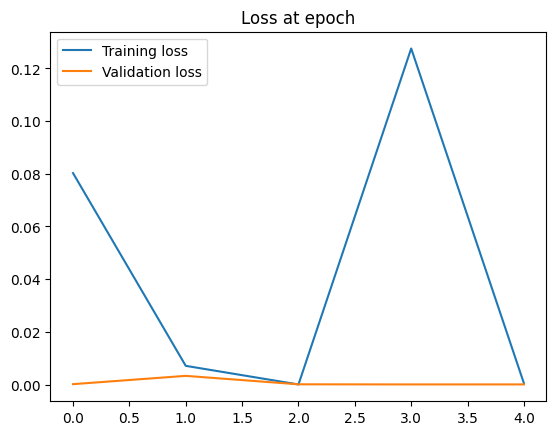

In [161]:
#graph loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses,label="Training loss")
plt.plot(test_losses,label="Validation loss")
plt.title("Loss at epoch")
plt.legend()

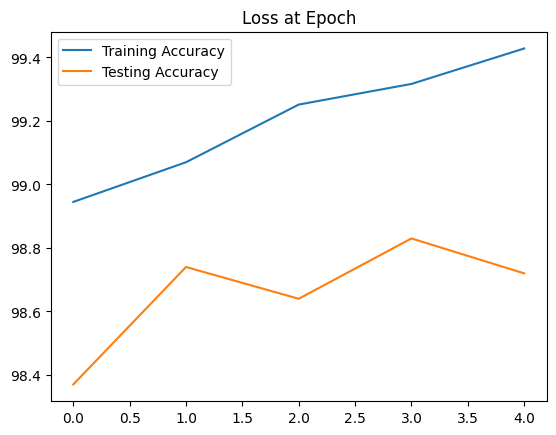

In [163]:
#graph accuracy
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Testing Accuracy")
plt.title("Loss at Epoch")
plt.legend()

In [164]:
test_load_everything = DataLoader(test_data, batch_size=10000,shuffle=False)


In [169]:
with torch.no_grad():
  correct = 0
  for X_test,Y_test in test_load_everything:
    Y_val = model(X_test)
    predicted = torch.max(Y_val,1)[1]
    correct += (predicted == Y_test).sum()

In [173]:
correct.item()/len(test_data) *100

98.72

In [176]:
  #grab an image
  test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

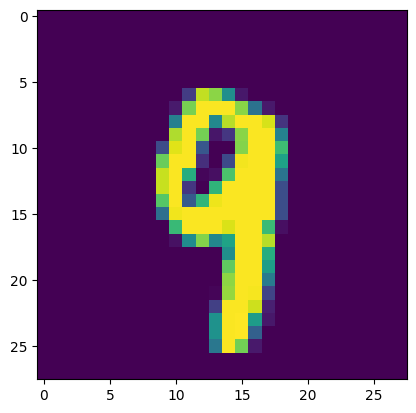

In [177]:
plt.imshow(test_data[4143][0].reshape(28,28))

In [178]:
#pass img through model

model.eval()
with torch.no_grad():
  new_pred = model(  test_data[4143][0].view(1,1,28,28))

In [179]:
new_pred #probablities

tensor([[-2.5877e+01, -2.2972e+01, -3.1056e+01, -2.4929e+01, -1.5141e+01,
         -2.7893e+01, -3.6476e+01, -1.6906e+01, -1.8305e+01, -2.3842e-07]])

In [180]:
new_pred.argmax()

tensor(9)